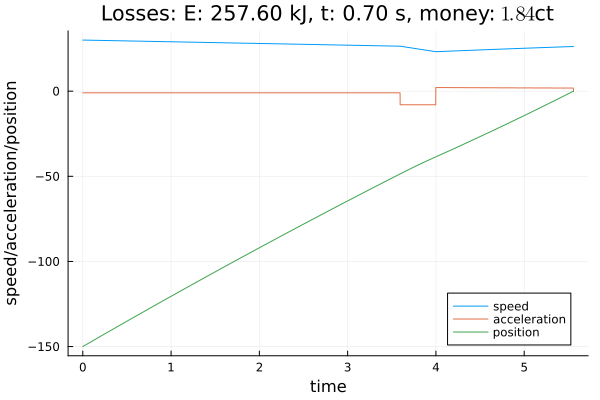

0.05936800136146958

In [9]:
using Plots
using Distributions
using Random
using Printf

# car parameters
mass=1500.0 #kg
power=80e3 #W
brake_acceleration=8.0 #m/s^2
Cd=0.4 # drag coefficient
A=2.0 # frontal area
min_speed=0.05 #m/s
cost_per_J=1.85/(45e6)#$/J
cost_pers_s=40/(60*60)#$/s

rho=1.2 # air density
time_to_green_distribution=Exponential(6.0)
initial_speed=30.0 #m/s
initial_position=-150.0 #m
safety_distance=5.0 #m


discretization=5000
sampling_count=1000
locations=range(initial_position, stop=0.0, length=discretization)
Strategy=Vector # acceleration at every position step
struct Trajectory
    acceleration::Vector
    speed::Vector
    time::Vector
    energy::Float64
    lost_time::Float64
    lost_energy::Float64
end

function clip_acceleration(acceleration::Float64,v)
    if v>=initial_speed
        return min(acceleration,0)
    end
    drag_force=0.5*rho*Cd*A*v^2
    return clamp(acceleration,-brake_acceleration,min((power/(v+min_speed)-drag_force)/mass,10))
end
function compute_power(acceleration::Float64,v)
    drag_force=0.5*rho*Cd*A*v^2
    acceleration_force=max(0,acceleration)*mass
    return (drag_force+acceleration_force)*v
end


function simulate(s::Strategy, time_to_green::Float64)::Trajectory
    # initialize
    acceleration=zeros(length(s))
    speed=zeros(length(s))
    time=zeros(length(s))
    speed[1]=initial_speed
    # simulate
    t=0
    energy=0.0
    for i in 2:length(s)
        time[i]=t
        dt=(locations[i]-locations[i-1])/speed[i-1]
        a=s[i-1]
        if t<time_to_green
            distance_to_stop=speed[i-1]^2/(2*brake_acceleration)
            if distance_to_stop>=abs(locations[i])-safety_distance
                a=-Inf
            end
        else
            if speed[i-1]<initial_speed
                a=Inf
            else
                a=0.0
            end
        end
        if speed[i-1]<=min_speed && a<=0
            a=0.0
            acceleration[i-1]=a
            speed[i]=min_speed
            t=time_to_green-1e-6
            continue
        end
        a=clip_acceleration(a,speed[i-1])
        acceleration[i-1]=a
        energy+=compute_power(a,speed[i-1])*dt
        t+=dt
        speed[i]=speed[i-1]+a*dt
        if speed[i]<=min_speed
            speed[i]=min_speed
        end
    end
    last_speed=speed[end]
    v=last_speed
    last_time=time[end]
    x=0.0
    while v<initial_speed
        dt=1e-3
        t+=dt
        a=clip_acceleration(Inf,v)
        v+=a*dt
        x+=v*dt
        energy+=compute_power(a,v)*dt
    end
    time_without_break=(x-initial_position)/initial_speed
    time_actual=t
    energy_without_break=compute_power(0.0,initial_speed)*time_without_break
    # println("time without break: $(time_without_break) s")
    # println("time actual: $(time_actual) s")
    # println("energy without break: $(energy_without_break/1e3) kJ")
    # println("energy actual: $(energy/1e3) kJ")
    return Trajectory(acceleration,speed,time,energy,time_actual-time_without_break,energy-energy_without_break)
end

function loss(t::Trajectory)
    return t.lost_energy*cost_per_J+t.lost_time*cost_pers_s
end

no_action_strategy=Strategy(-1*ones(discretization))
function plot_trajectory(t::Trajectory)
    p=plot(t.time,t.speed,label="speed")
    plot!(p,t.time,t.acceleration,label="acceleration")
    plot!(p,t.time,locations,label="position")
    plot!(p,xlabel="time",ylabel="speed/acceleration/position")
    title!(p,"Losses: E: $(@sprintf("%.2f", t.lost_energy/1e3)) kJ, t: $(@sprintf("%.2f", t.lost_time)) s, money: \$ $(@sprintf("%.2f", loss(t)*100))\$ct")
    return p
end
trj=simulate(no_action_strategy,4.0)
plot_trajectory(trj) |> display

function loss(s::Strategy)
    times_to_green=rand(time_to_green_distribution,sampling_count)
    losses=zeros(sampling_count)
    Threads.@threads for i in 1:sampling_count
        trj=simulate(s,times_to_green[i])
        losses[i]=loss(trj)
    end
    return sum(losses)/sampling_count
end
print(loss(no_action_strategy))